In [1]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
# ML and Metrics module
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Data APIs
import yfinance as yf
from pytrends.request import TrendReq

# Technical indicators
from ta.momentum import rsi, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement
from scipy.signal import savgol_filter, convolve, lfilter


from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope

Loading BokehJS ...

# Load the data

In [2]:
SYMBOL= 'BTC'
df = loadFromDB(SYMBOL,'1h')
df = computeLaggingLinearRegression(df,window=10,filter_ceof=True, derivative=True,filter_method='savgol')
#df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,
2020-06-01 13:00:00,9555.65,9571.99,9543.64,9553.62,1266.849892,1591016400,-0.000415,0.000064,-0.000172
2020-06-01 14:00:00,9553.14,9580.72,9547.06,9563.03,1924.365247,1591020000,-0.000063,0.000034,-0.000142
2020-06-01 15:00:00,9563.13,9565.43,9500.00,9546.98,1915.784823,1591023600,0.000312,-0.000337,-0.000415
2020-06-01 16:00:00,9548.18,9610.00,9536.99,9584.28,3086.584917,1591027200,0.000173,-0.000557,-0.000621
2020-06-01 17:00:00,9584.29,9592.59,9563.26,9575.29,1176.977333,1591030800,0.000579,-0.000390,-0.000424


# Drawing Lines

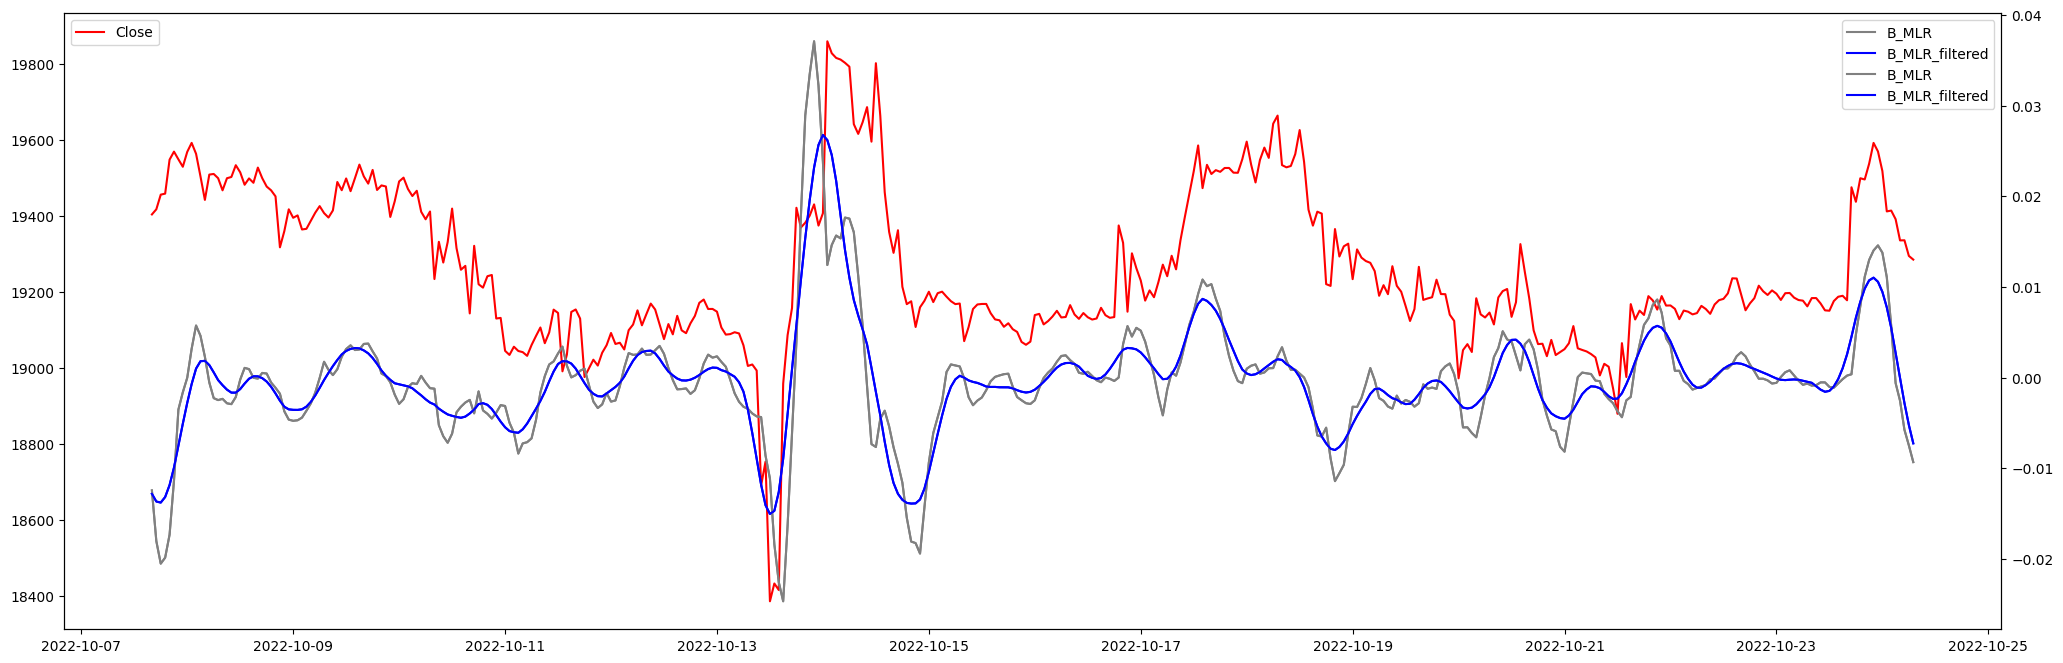

In [3]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_right = ax_left.twinx()

ax_left.plot(df.Close[-400:], color='red',label='Close')
ax_right.plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right.plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_left.legend(loc="upper left")
ax_right.plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right.plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_right.legend(loc="upper right")


# Creating a strategy

Period : [2020-06-01 13:00:00] -> [2022-10-24 07:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 97236507.09 $
Performance vs US Dollar : 9723550.71 %
Buy and Hold Performence : 101.87 %
Performance vs Buy and Hold : 9545333.47 %
Best trade : +18.3 %, the 2021-05-20 13:00:00
Worst trade : -6.66 %, the 2022-06-13 22:00:00
Worst drawBack : -7.000000000000001 %
Total fees :  16319613.77 $

----- Trades Informations -----
Total trades on period : 1042
Number of positive trades : 731
Number of negative trades :  311
Trades win rate ratio : 70.15 %
Average trades performance : 1.21 %
Average positive trades : 2.05 %
Median positive trades : 1.34 %
Average negative trades : -0.79 %
Median negative trades : -0.48 %

----- Plot -----


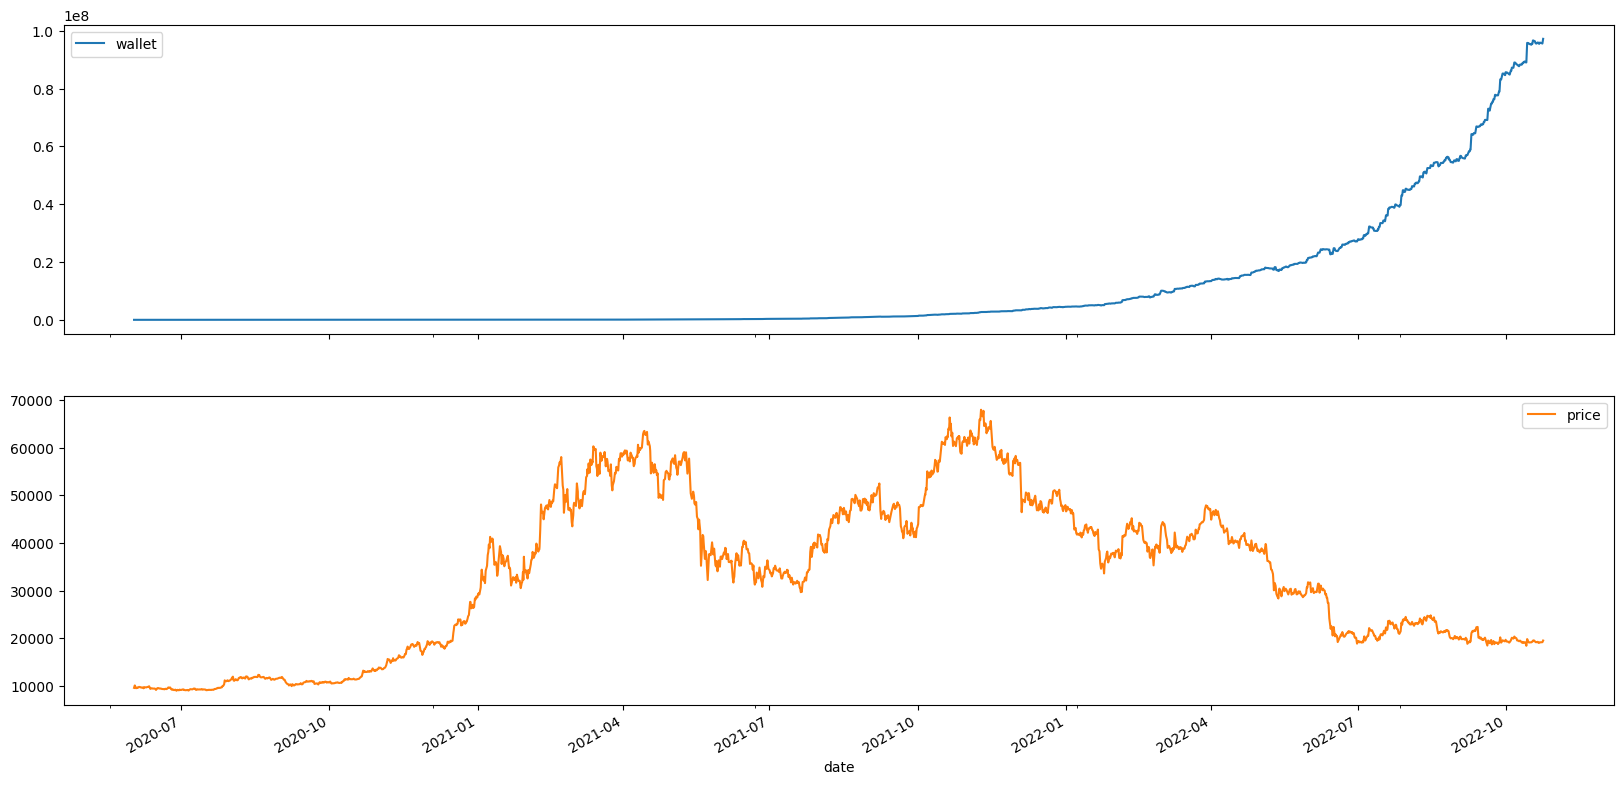

In [4]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# ML classify trade

In [5]:
df['Prev_B_MLR_coefs_filtered_diff'] = df.B_MLR_coefs_filtered_diff.shift(1)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff,Prev_B_MLR_coefs_filtered_diff
Date,,,,,,,,,,
2020-06-01 14:00:00,9553.14,9580.72,9547.06,9563.03,1924.365247,1591020000,-0.000063,0.000034,-0.000142,-0.000172
2020-06-01 15:00:00,9563.13,9565.43,9500.00,9546.98,1915.784823,1591023600,0.000312,-0.000337,-0.000415,-0.000142
2020-06-01 16:00:00,9548.18,9610.00,9536.99,9584.28,3086.584917,1591027200,0.000173,-0.000557,-0.000621,-0.000415
2020-06-01 17:00:00,9584.29,9592.59,9563.26,9575.29,1176.977333,1591030800,0.000579,-0.000390,-0.000424,-0.000621
2020-06-01 18:00:00,9575.29,9587.01,9555.24,9579.70,996.499709,1591034400,0.001318,0.000303,0.000639,-0.000424
...,...,...,...,...,...,...,...,...,...,...
2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.903960,1666580400,-0.000604,0.002722,-0.006741,-0.005079
2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.789880,1666584000,-0.002542,-0.000084,-0.007836,-0.006741
2022-10-24 05:00:00,19336.06,19355.70,19292.65,19336.43,7984.151790,1666587600,-0.005752,-0.002803,-0.008297,-0.007836


In [65]:
def process_trade(row)->int:
    if row['Prev_B_MLR_coefs_filtered_diff']<0 and row['B_MLR_coefs_filtered_diff']>0:
        return 1
    elif row['Prev_B_MLR_coefs_filtered_diff']>0 and row['B_MLR_coefs_filtered_diff']<0:
        return 1
    else:
        return 0

df['Trade'] = df.apply(process_trade,axis=1)
df_copy = df.copy()

df_copy.drop(columns=['Timestamp','B_MLR_coefs_filtered','B_MLR_coefs_filtered_diff','Prev_B_MLR_coefs_filtered_diff'],inplace=True)
df_copy = addIndicators(df_copy)
df_copy = computeRSI_VWAP(df_copy)
df_copy = computeTrixIndicator(df_copy, col='Close')
df_copy['Last_hour_Trade'] = df_copy['Trade'].shift(1)
df_copy.dropna(inplace=True)
df_copy

,Open,High,Low,Close,Volume,B_MLR_coefs,Trade,High_Low_diff,EMA20,EMA50,...,ADX,ATR,CCI,OVB,OVB_EMA200,EVM,RSI_VWAP,Trix,Trix_histo,Last_hour_Trade
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-12 19:00:00,9397.98,9450.00,9350.00,9431.21,2106.441872,-0.003450,0,100.00,9432.644887,9517.335400,...,38.520633,85.213710,-43.522488,-14052.617516,-7890.876468,1.418743e+08,29.111910,9425.905304,0.106861,0.0
2020-06-12 20:00:00,9431.11,9485.71,9409.85,9466.32,1236.722212,-0.003318,0,75.86,9435.852041,9515.334796,...,37.187784,84.278339,24.793994,-12815.895304,-7939.881630,2.930804e+08,30.151459,9425.968354,0.092892,0.0
2020-06-12 21:00:00,9466.32,9475.89,9426.76,9439.43,695.141259,-0.002391,0,49.13,9436.192799,9512.358137,...,35.950139,80.763505,9.461261,-13511.036563,-7995.316008,2.505474e+07,30.791031,9426.176454,0.079894,0.0
2020-06-12 22:00:00,9439.27,9488.00,9438.01,9477.95,932.187877,-0.001309,1,49.99,9440.169675,9511.008799,...,34.551217,77.686154,49.514890,-12578.848686,-8040.923298,6.263579e+07,31.971456,9426.851364,0.070809,0.0
2020-06-12 23:00:00,9478.16,9488.15,9441.24,9465.13,902.868965,-0.000118,0,46.91,9442.546849,9509.209630,...,33.248985,74.608539,42.731066,-13481.717651,-8095.060555,8.780665e+06,32.685728,9428.001321,0.062582,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.903960,-0.000604,0,93.19,19378.197625,19280.460556,...,29.973290,98.766085,-18.476334,62569.869432,130211.326393,-4.134506e+07,89.607513,19339.709687,0.050067,0.0
2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.789880,-0.002542,0,132.41,19374.184518,19282.640927,...,27.979084,102.130476,-69.703963,51995.079552,129433.055280,-7.853352e+07,89.131232,19353.731705,0.031329,0.0
2022-10-24 05:00:00,19336.06,19355.70,19292.65,19336.43,7984.151790,-0.005752,0,63.05,19370.588849,19284.750302,...,26.127322,98.222429,-86.575299,59979.231342,128741.972455,-1.603069e+06,89.138594,19364.645057,0.012521,0.0


<AxesSubplot: >

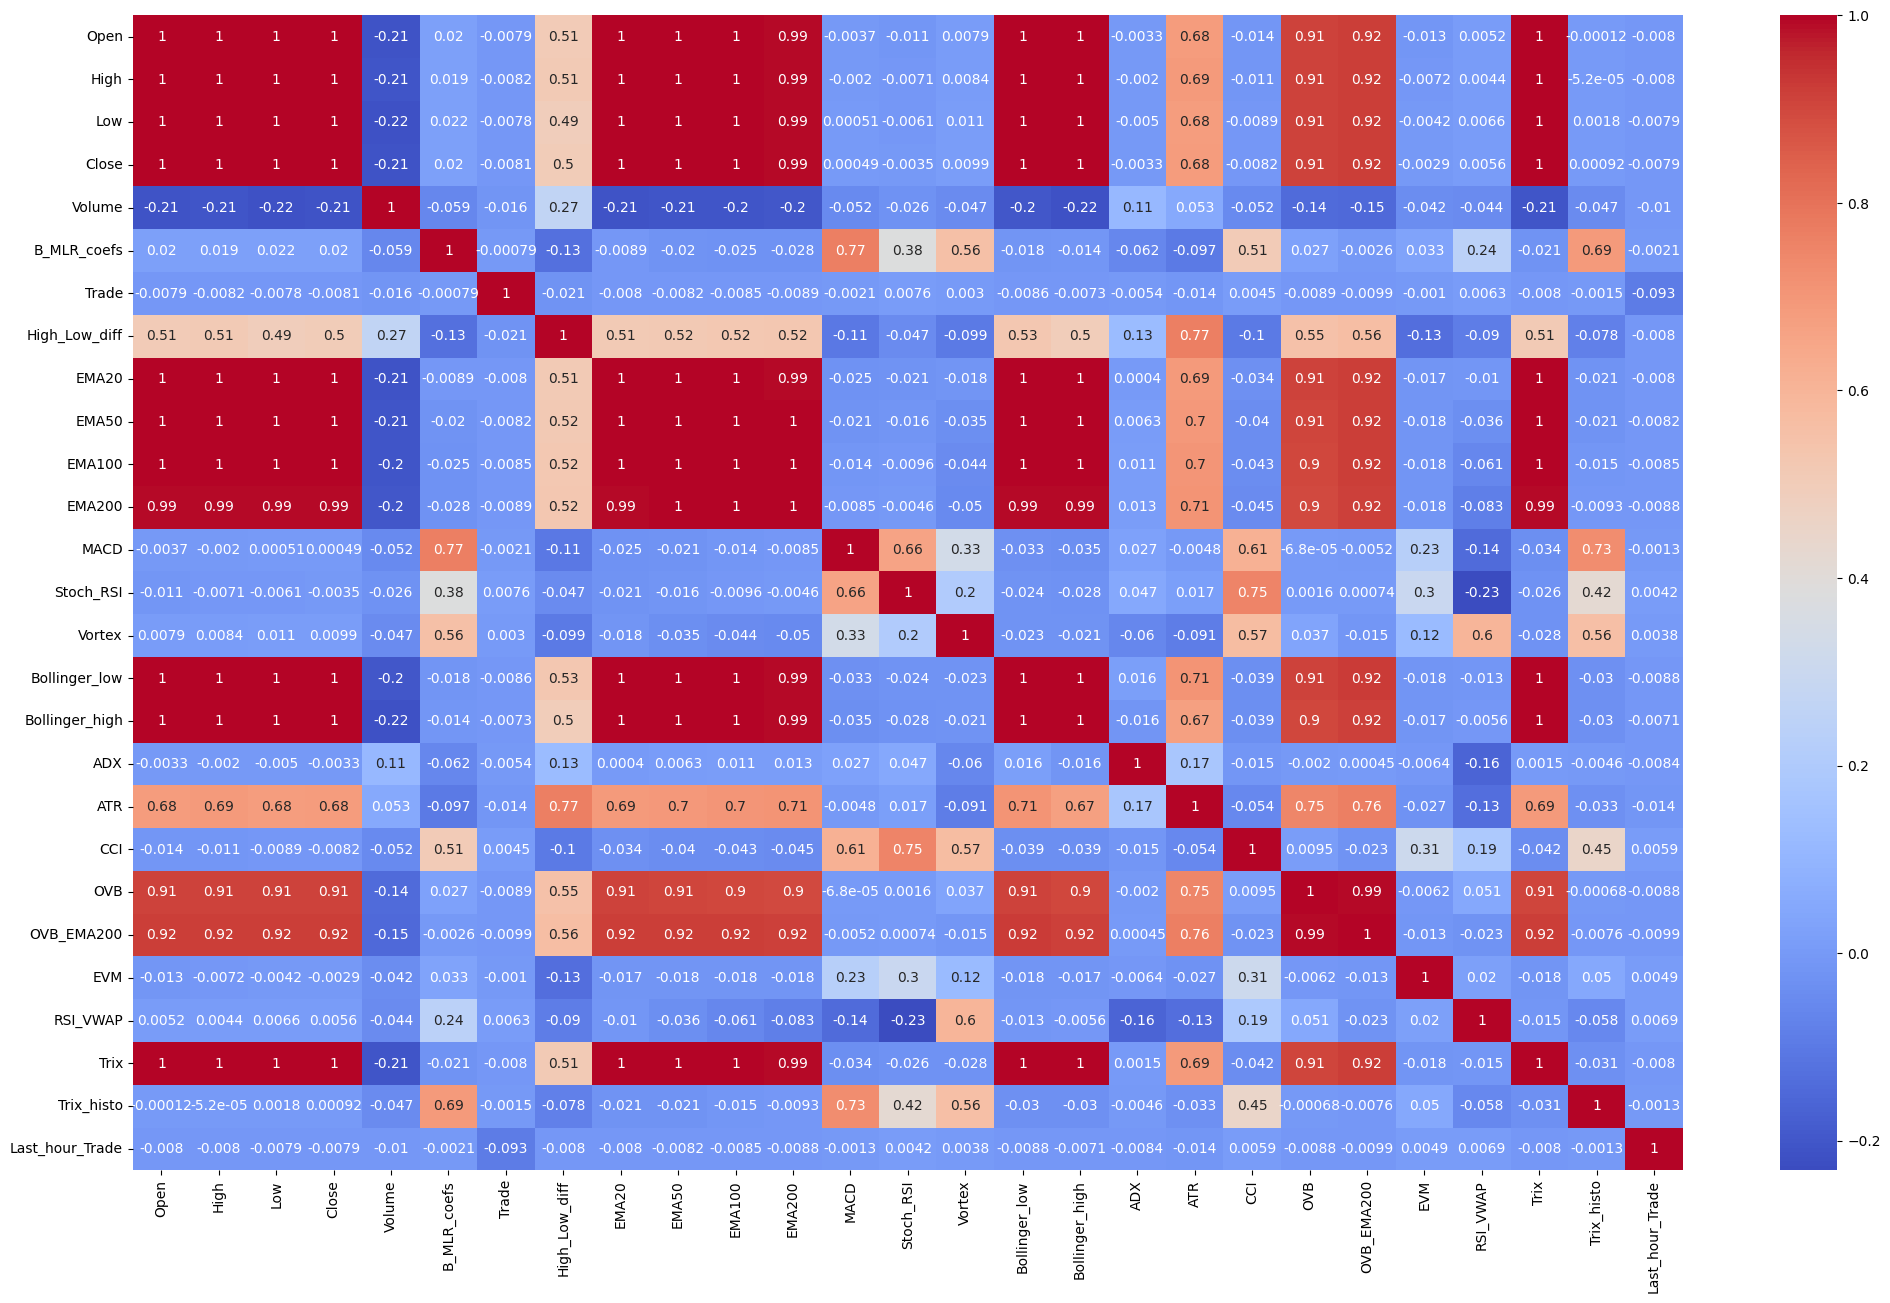

In [66]:
fig, ax = plt.subplots(1, figsize=(25,15))
import seaborn as sns

sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm',
        xticklabels=df_copy.columns,
        yticklabels=df_copy.columns,ax=ax)

### Imbalance handling 1

In [67]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df_copy[(df_copy['Trade']==0)] 
df_minority = df_copy[(df_copy['Trade']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_majority), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

### Imbalance handling 2

In [68]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_copy.drop('Trade', axis=1), df_copy['Trade'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = oversampled.Trade.values.reshape(-1,1)
X = oversampled.drop(columns=['Trade'])

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

In [80]:
from sklearn.decomposition import PCA

decorrelator = PCA(n_components=12)
X_scaled = decorrelator.fit_transform(X_scaled)

In [81]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

select = SelectKBest(score_func=f_classif, k='all')
z = select.fit_transform(X_scaled,y)
X_scaled=z

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,shuffle=True)

In [83]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((12,)))
model.add(Dense(units = 32,activation=keras.activations.relu))
model.add(Dense(units = 16,activation=keras.activations.relu))
model.add(Dropout(0.2))
model.add(Dense(units = 1,activation=keras.activations.sigmoid))

model.compile(optimizer = Adam(learning_rate=0.01), loss = 'binary_crossentropy',metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=75,
          shuffle=True,
          batch_size=128,
          validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                        verbose=1,
                                                       patience=8,
                                                       min_delta=0.00005,
                                                       mode='max',
                                                       restore_best_weights=True)],
          use_multiprocessing=True)

print(f'Accuracy : {100*model.evaluate(X_test,y_test)[-1]:.1f} %')

Epoch 1/75
187/187 [==============================] - 2s 6ms/step - loss: 0.5880 - accuracy: 0.6813 - val_loss: 0.5387 - val_accuracy: 0.7196
Epoch 2/75
187/187 [==============================] - 1s 4ms/step - loss: 0.5292 - accuracy: 0.7287 - val_loss: 0.5063 - val_accuracy: 0.7433
Epoch 3/75
187/187 [==============================] - 1s 5ms/step - loss: 0.5078 - accuracy: 0.7466 - val_loss: 0.4931 - val_accuracy: 0.7509
Epoch 4/75
187/187 [==============================] - 1s 4ms/step - loss: 0.4979 - accuracy: 0.7530 - val_loss: 0.4910 - val_accuracy: 0.7514
Epoch 5/75
187/187 [==============================] - 1s 4ms/step - loss: 0.4922 - accuracy: 0.7546 - val_loss: 0.4877 - val_accuracy: 0.7507
Epoch 6/75
187/187 [==============================] - 1s 4ms/step - loss: 0.4855 - accuracy: 0.7562 - val_loss: 0.4775 - val_accuracy: 0.7611
Epoch 7/75
187/187 [==============================] - 1s 4ms/step - loss: 0.4842 - accuracy: 0.7600 - val_loss: 0.4740 - val_accuracy: 0.7641
Epoch 

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
clf.score(X=X_test,y= y_test)

0.7420305384409323

In [119]:
parameters = {'n_estimators':(80,150, 200),
              'loss':( 'log_loss', 'deviance', 'exponential'),
              'subsample':[0.5,0.75,1]}

clf = GradientBoostingClassifier()
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

grid = RandomizedSearchCV(clf, parameters,n_jobs=10,verbose=1)
grid.fit(X_train, y_train)
grid.score(X=X_test,y= y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/baptiste/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/baptiste/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/baptiste/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/baptiste/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the 

0.7372438730413821

In [116]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
clf.score(X=X_test,y= y_test)

0.6951921789205839

# Optimization

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocess import cpu_count

results=[]

SYMBOL= 'BTC'
#df = loadFromDB(SYMBOL,'1h',True)
#df = df.iloc[-8000:]
#df = computeLaggingLinearRegression(df,window=25,filter_ceof=False, derivative=False,filter_method='savgol')
#df.dropna(inplace=True)

for window in range(5,50,3):
    #for polyorder in range(10,150,10):
        df = loadFromDB(SYMBOL,'1h',True)
        df = df.iloc[-8000:]
        df = computeLaggingLinearRegression(df,window=window,filter_ceof=False, derivative=False,filter_method='savgol')
        df.dropna(inplace=True)
        df_final = pd.DataFrame()

        def process_one_row(df_i):
            #fft_denoiser   
            #cycle, trend = hpfilter( df_i['EMA20'].values,polyorder) #trend
            df_i['B_MLR_coefs_denoised'] =savgol_filter(df_i.B_MLR_coefs.values, polyorder, 2, mode='nearest')#trend#explicit_heat_smooth(df_i.EMA20.values, 4)#polynomialRegression(df_i.Close.values,5,False)#filterData(df.EMA20.values,'hpf')#
            df_i['B_MLR_coefs_denoised_diff'] = df_i.B_MLR_coefs_denoised.diff(1)
            df.dropna(inplace=True)
            return df_i.iloc[-1]
            
        with ThreadPoolExecutor(max_workers=20) as executor:
            processes = [executor.submit(process_one_row, df.iloc[i-1500:i]) for i in range(1500,len(df))]

        for task in as_completed(processes):
            df_final = df_final.append(task.result())
            
        df_final.sort_index(inplace=True)

        #print('Testing strategy : ')
        def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
            return True if row.B_MLR_coefs_denoised_diff>0 else False

        def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
            return True if row.B_MLR_coefs_denoised_diff<0 else False
        #strategyTester(df_final,buyCondition,sellCondition,equity=1000, optimization_process=False)
        coins = strategyTester(df_final,buyCondition,sellCondition,equity=1000, optimization_process=True)
        result = {'window':window,'polyorder':polyorder,'coins':coins}
        print(result)
        results.append(result)

In [ ]:
result = []

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

for i in range(5,15, 1):
    df = computeLaggingLinearRegression(loadFromDB(SYMBOL).iloc[-10000:],
                                        window=i,filter_ceof=True, derivative=True,filter_method='savgol')
    equity = strategyTester(df.iloc[-7000:],buyCondition,sellCondition,optimization_process=True)
    print({'window':i,'balance':equity})
    result.append({'window':i,'balance':equity})

# Denoising

In [ ]:
import multiprocessing

model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0, n_jobs=multiprocessing.cpu_count())
model.fit(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)
model.score(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)

In [ ]:
len(df.B_MLR_coefs_filtered.values)

In [ ]:
WINDOW=20

X = np.array([df.B_MLR_coefs.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])
y = np.array([df.B_MLR_coefs_filtered.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])

fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 165
ax_left.plot(list(range(WINDOW)),X[ind], color='red',label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax_left.legend(loc="upper left")

# Denoising autoencoder

In [ ]:
from keras.layers import Conv1D, Conv1DTranspose
from keras.models import Sequential
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
import multiprocessing

max_norm_value = 2.0
input_shape = (WINDOW,1 )


# Create the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='linear', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001,restore_best_weights=True,patience=4 ,verbose=1)

model.fit(X, y,
        epochs=5,
        batch_size=128,
        validation_split=0.3,
        use_multiprocessing=True,
        workers=multiprocessing.cpu_count(),
        callbacks=[es])


In [ ]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 163
ax_left.plot(list(range(WINDOW)),X[ind], color='black',alpha=0.2,label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax = ax_left.twinx()
ax.plot(list(range(WINDOW)),model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], color='yellow',label='Prediction')
ax.plot(list(range(WINDOW)),savgol_filter(model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], 10, 2, mode='nearest'), color='red',label='Filtered Prediction')

ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

In [ ]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()

In [ ]:
df = df.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tweets = df_tweets.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tvta = df_tvta.loc[pd.to_datetime(df.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df.head()

In [ ]:
def generateHourlyDataFormTweets(tweet_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tweet_df['join_key'] = tweet_df.apply(createJoinKey, axis=1)
    tweet_df = tweet_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tweet_df['Date']=tweet_df.apply(recreateDates, axis=1)
    tweet_df = tweet_df.set_index('Date').sort_index(axis=0)
    return tweet_df.drop(columns=['join_key','timestamp'])
    
df_tweets = generateHourlyDataFormTweets(df_tweets)
df_tweets

In [ ]:
def generateHourlyDataFormTVTA(tvta_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tvta_df['join_key'] = tvta_df.apply(createJoinKey, axis=1)
    tvta_df = tvta_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tvta_df['Date']=tvta_df.apply(recreateDates, axis=1)
    tvta_df = tvta_df.set_index('Date').sort_index(axis=0)
    return tvta_df.drop(columns=['join_key','timestamp'])
    
df_tvta = generateHourlyDataFormTVTA(df_tvta)
df_tvta